In [ ]:
%%system
rm /scratch/ors -r
mkdir /scratch/ors
mkdir /scratch/ors/clr
mkdir /scratch/ors/dmg
cp ~/ors-project/data.tar.gz /scratch/ors
tar -xzvf /scratch/ors/data.tar.gz --directory /scratch/ors/
mv /scratch/ors/patches_256_v2/ /scratch/ors/clr_three_band

In [1]:
from fastai.vision.all import *
from PIL import Image, ImageDraw
from random import randint

In [2]:
import wandb
from fastai.callback.wandb import *
wandb.init(project="ors_project", entity="android100")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: android100 (use `wandb login --relogin` to force relogin)


In [3]:
path = Path("/scratch/ors/")
path_three_band = path/"clr_three_band"
path_clear = path/"clr"
path_damaged = path/"dmg"

In [4]:
LINE_WIDTH = 2
STRIP_IMAGE_SIZE = 512

In [11]:
def damage_image(image_path):  
    img = Image.open(image_path)
    img = np.array(img) / 255
    
    for i in range(img.shape[-1]):
        image_name = image_path.name[:-len(".png")] + "_" + str(i) + ".png"
        band = img[:, :, i]
        
        stripes_base = Image.new("L", (STRIP_IMAGE_SIZE, STRIP_IMAGE_SIZE), (255))
        stripes = ImageDraw.Draw(stripes_base)

        color = "BLACK"

        for y in range(int(1.1 * LINE_WIDTH), int(STRIP_IMAGE_SIZE - 0.1 * LINE_WIDTH), 20):
            stripes.line([0, y, STRIP_IMAGE_SIZE, y], width=LINE_WIDTH, fill=color)

        damage_lines = stripes_base.rotate(random.randint(0, 360))
        damage_lines = damage_lines.crop(((STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE + 256)/2, (STRIP_IMAGE_SIZE + 256)/2, ))
        damage_lines = np.array(damage_lines) / 255
    
        damaged_band = band * damage_lines
        
        damaged_band = np.uint8(damaged_band * 255)
        damaged_band = Image.fromarray(damaged_band)
        damaged_band.save(path_damaged/image_name)
        
        band = np.uint8(band * 255)
        band = Image.fromarray(band)
        band.save(path_clear/image_name)

In [12]:
parallel(damage_image, path_three_band.ls(), n_workers=8, progress=True)

(#12900) [None,None,None,None,None,None,None,None,None,None...]

In [13]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                  get_items=get_image_files,
                  get_y=lambda x: path_clear/x.name,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(224),
                  batch_tfms=[*aug_transforms(max_zoom=2.),
                             Normalize.from_stats(*imagenet_stats)])

In [14]:
dls = dblock.dataloaders(path_damaged, bs=8)

/home2/s.ranjan/miniconda3/envs/ors/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [15]:
dls_gen = dls
dls_gen.c = 3

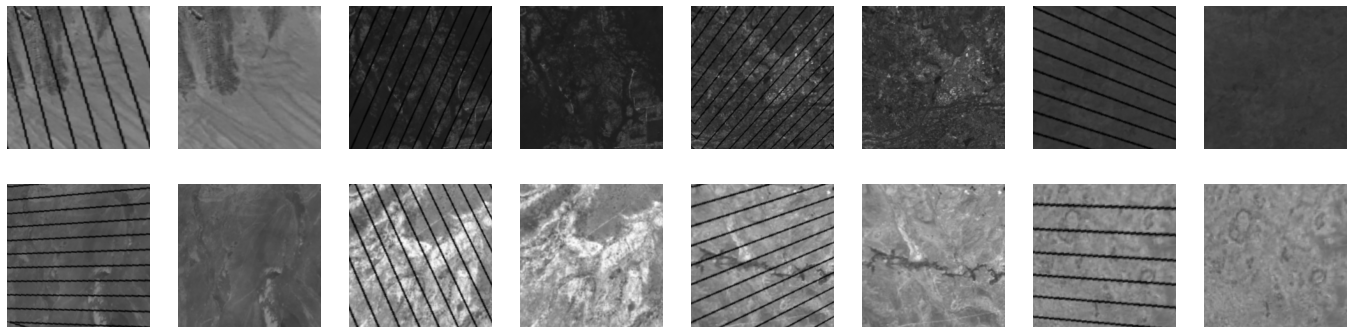

In [20]:
dls_gen.show_batch()

In [17]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [18]:
bbone = resnet34
# cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
#                   y_range=y_range)

In [19]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen, cbs=WandbCallback())

In [21]:
learn_gen = create_gen_learner()

In [22]:
learn_gen.fit_one_cycle(15, pct_start=0.8, wd=wd)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.009018,0.014832,11:18
1,0.005450,0.007274,11:18
2,0.004735,0.005925,11:19
3,0.004202,0.006950,11:18
4,0.004342,0.005272,11:18
5,0.003968,0.005702,11:19
6,0.003577,0.004893,11:17
7,0.003292,0.004681,11:18
8,0.003227,0.005363,11:17
9,0.003237,0.005227,11:17


In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(5, slice(1e-6,1e-3), wd=wd)

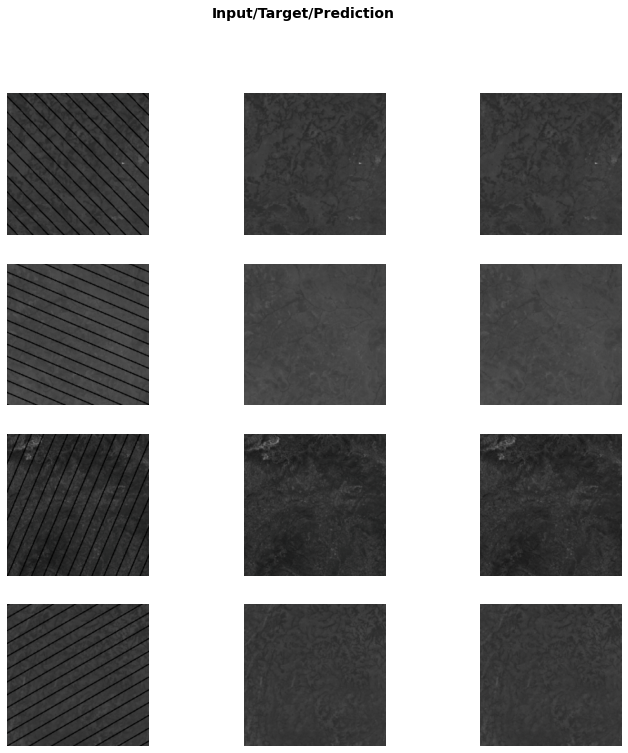

In [23]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [25]:
learn_gen.save('image_restoration_single_band_process')

Path('models/image_restoration_single_band_process.pth')

In [26]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇███████▇▆▅▄▂▁▁
lr_1,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇███████▇▆▅▄▂▁▁
lr_2,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇███████▇▆▅▄▂▁▁
mom_0,██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▃▄▅▇██
mom_1,██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▃▄▅▇██
mom_2,██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▃▄▅▇██
raw_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
